In [1]:
import random
import shutil
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder


In [2]:
# !pip install torch torchvision torchaudio

##### 1. Firstly we'll randomly split our entire data and create new folders for both test and train data, mainting a 80:20 split.

In [3]:
os.mkdir('q9_image_nn_train')
os.mkdir('q9_image_nn_test')

In [4]:
#defining folder names
source_folder = 'EuroSAT_RGB'
train_folder = 'q9_image_nn_train'
test_folder = 'q9_image_nn_test'

# determining subfolders and sort
subfolders = os.listdir(source_folder)
subfolders.sort()

image_class = 0
class_dict = {}
for folder_name in subfolders:
    if folder_name[0] != '.':#ensure no hidden folder
        subfolder_images = os.listdir(source_folder + '/' + folder_name)
        #initializing training set sample size
        sample_size = int(len(subfolder_images) * 0.8)
        train_image_list = []
        #create the new subfolder at train folder
        new_subfolder = train_folder + '/' + str(image_class)
        os.mkdir(new_subfolder)
        #choose train images and copy to new location
        for file_name in random.sample(subfolder_images, sample_size):
            shutil.copy2(os.path.join(source_folder, folder_name, file_name), new_subfolder)
            train_image_list.append(file_name)
        
        #get the test set images, create new subfolder and copy test images
        test_image_list = list(set(subfolder_images) - set(train_image_list))
        new_subfolder = test_folder + '/' + str(image_class)
        os.mkdir(new_subfolder)
        for test_image in test_image_list:
            shutil.copy2(os.path.join(source_folder, folder_name, test_image), new_subfolder)
        
        class_dict[image_class] = folder_name
        image_class += 1

##### 2. Here we initialize our dataloaders

In [5]:
#create data loaders
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = torchvision.datasets.ImageFolder(root='q9_image_nn_train', transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)

test_data = torchvision.datasets.ImageFolder(root='q9_image_nn_test', transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=True, num_workers=2)

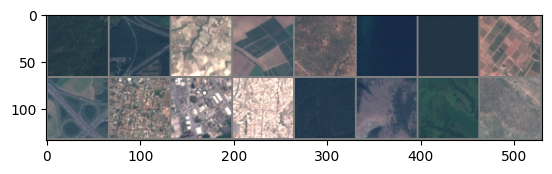

Labels: 1 3 6 6 2 9 9 6 3 7 4 7 1 2 5 2


In [6]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

##### 3. Define the CNN architecture

In [7]:
# # Let's define a simple CNN to classify digits

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
#         self.conv2 = nn.Conv2d(64, 128, 3, 1)
#         self.conv3 = nn.Conv2d(128, 256, 3, 1)
#         self.dropout1 = nn.Dropout(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
#         self.dropout2 = nn.Dropout(0.5)
#         self.dropout3 = nn.Dropout(0.7)
#         self.fc1 = nn.Linear(215296, 2048)
#         self.fc2 = nn.Linear(32768, 128)
#         self.fc3 = nn.Linear(2048, 512)
#         self.fc4 = nn.Linear(512, 128)
#         self.fc5 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(x)
#         x = self.conv2(x)
#         x = F.relu(x)
#         x = self.conv3(x)
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)
#         x = self.dropout1(x)
#         x = torch.flatten(x, 1)
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.dropout2(x)
#         # x = self.fc2(x)
#         # x = self.dropout3(x)
#         x = F.relu(x)
# #         x = self.fc3(x)
# #         x = F.relu(x)
# #         x = self.fc4(x)
# #         x = F.relu(x)
#         x = self.fc5(x)
#         return F.log_softmax(x, dim=1)

class Net(nn.Module):
    def __init__(self, num_classes=11):  # 11 types of land
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Adjusted input size
        self.fc2 = nn.Linear(512, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 6 * 6)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=11, bias=True)
)


In [8]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



##### 5. Training the model

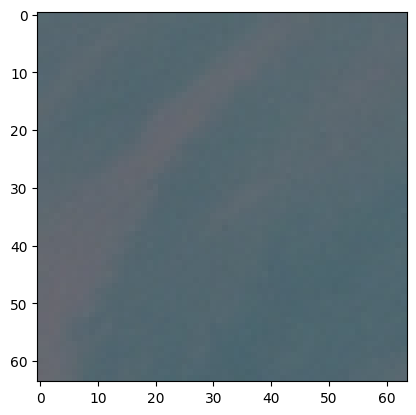

Predicted: 2
Actual: 9


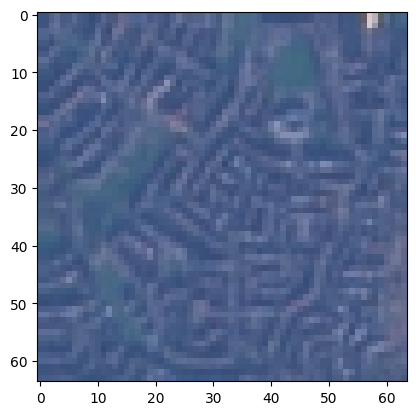

Predicted: 7
Actual: 7


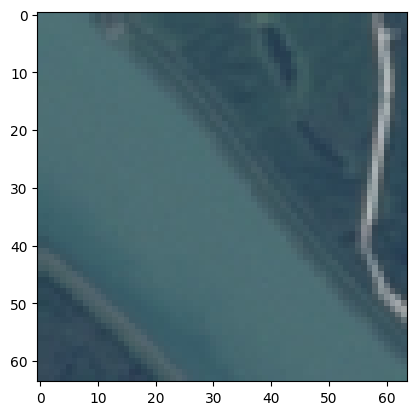

Predicted: 8
Actual: 8


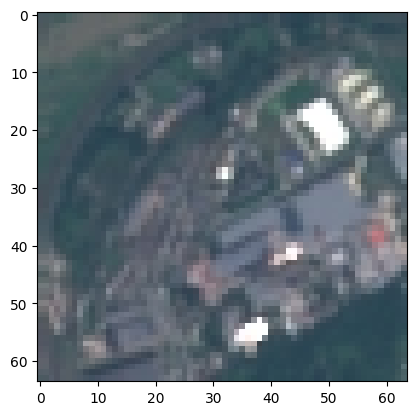

Predicted: 4
Actual: 4
Epoch 1, Loss: 1.0167623922316986


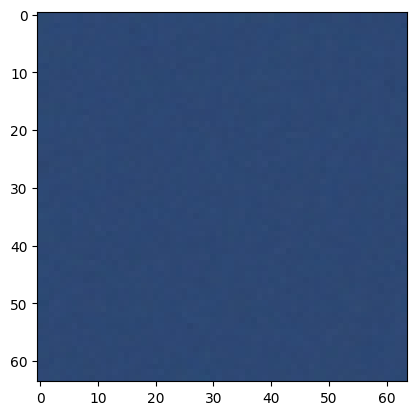

Predicted: 9
Actual: 9


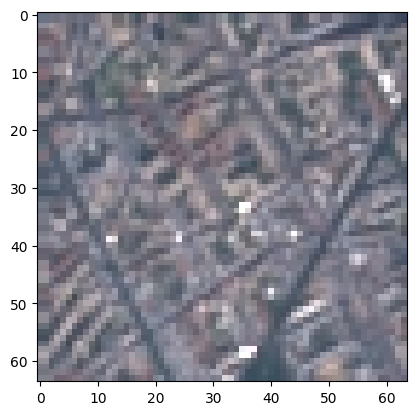

Predicted: 7
Actual: 7


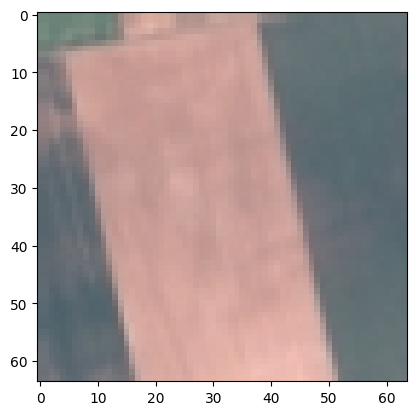

Predicted: 0
Actual: 0


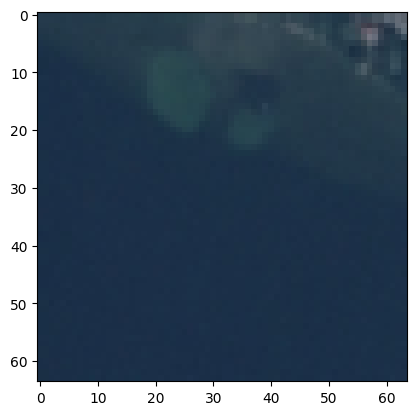

Predicted: 9
Actual: 9
Epoch 2, Loss: 0.6020918716869411


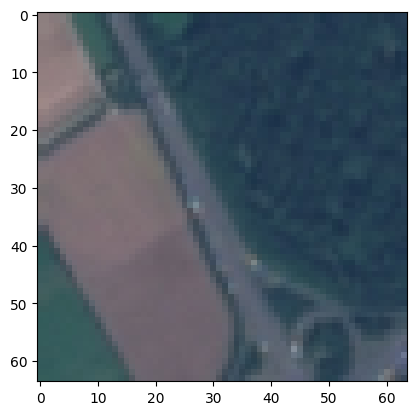

Predicted: 3
Actual: 3


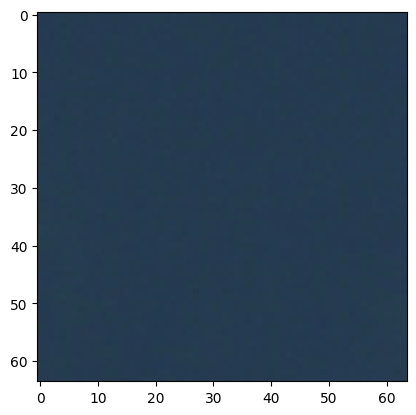

Predicted: 9
Actual: 9


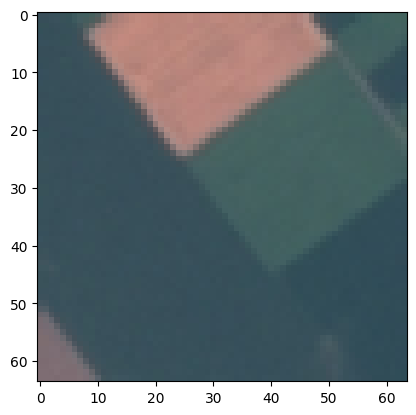

Predicted: 0
Actual: 0


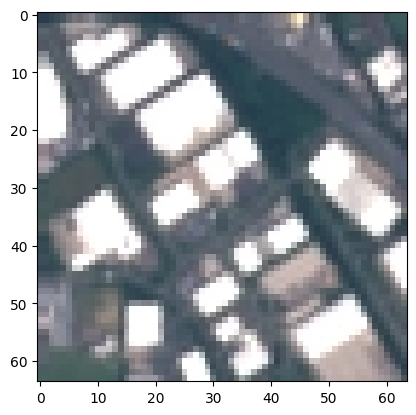

Predicted: 4
Actual: 4
Epoch 3, Loss: 0.4555857710143518


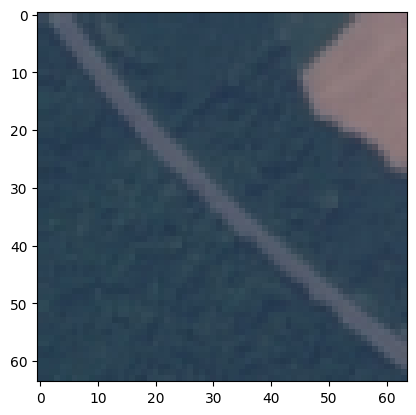

Predicted: 3
Actual: 3


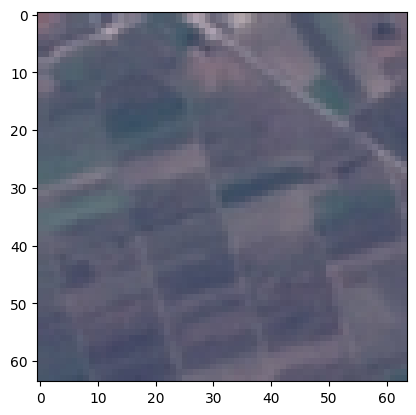

Predicted: 5
Actual: 6


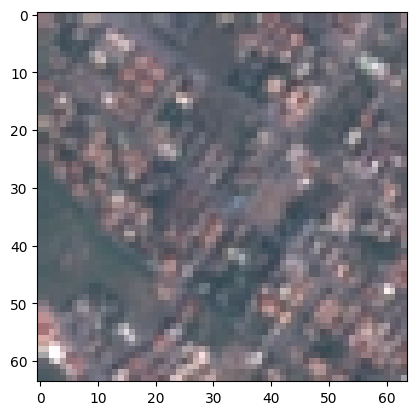

Predicted: 7
Actual: 7


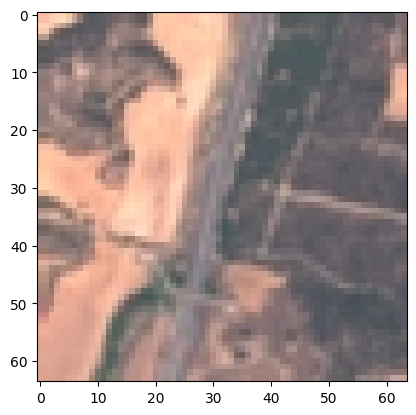

Predicted: 3
Actual: 3
Epoch 4, Loss: 0.3564061505290178


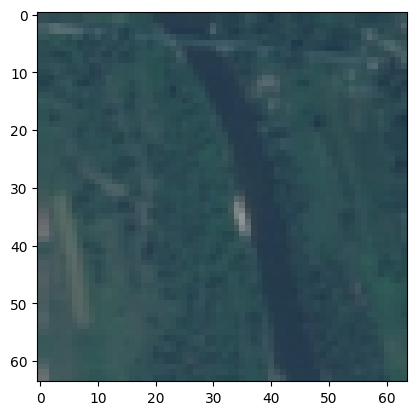

Predicted: 5
Actual: 8


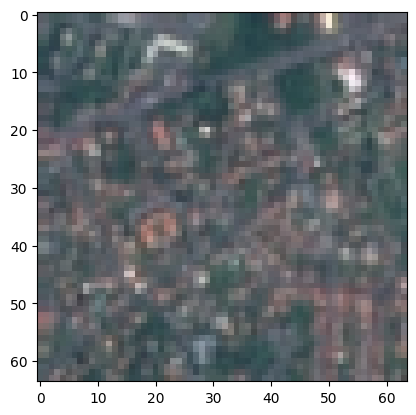

Predicted: 7
Actual: 7


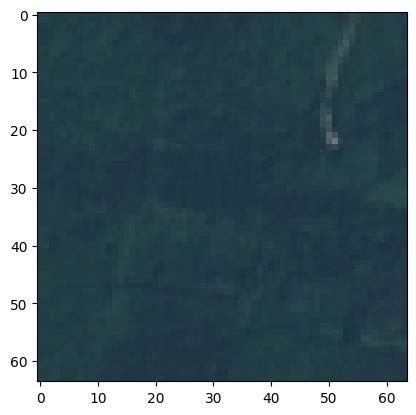

Predicted: 1
Actual: 1


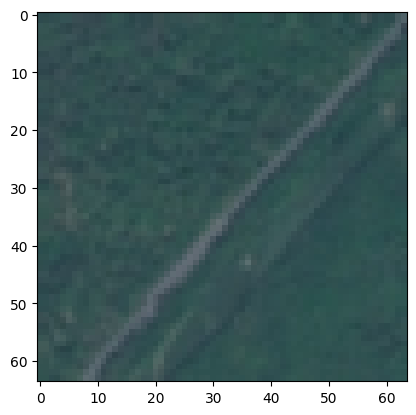

Predicted: 3
Actual: 3
Epoch 5, Loss: 0.2890144807435352
Finished Training


In [9]:
# Number of training epochs
num_epochs = 5

testiter = iter(test_data_loader)  # Create an iterator for test data

# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0  # Initialize running loss for each epoch

    for i, data in enumerate(train_data_loader, 0):  # Loop through training batches
        inputs, labels = data  # Separate inputs (images) and labels
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device (CPU or GPU)

        # Zero the parameter gradients
        optimizer.zero_grad()  # Reset gradients for each batch

        # Forward pass: Compute model outputs
        outputs = net(inputs)

        # Loss calculation: Measure discrepancy between predictions and labels
        loss = criterion(outputs, labels)

        # Backward pass: Propagate loss gradients back through the network
        loss.backward()

        # Optimize: Update model weights based on gradients
        optimizer.step()

        running_loss += loss.item()  # Accumulate batch losses

        if i % 100 == 0:  # Print periodic training progress (every 20 batches)
            with torch.no_grad():  # Disable gradient calculation for test data
                test_images, test_labels = next(testiter)  # Get a batch from test data
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # Visualize sample images (using torchvision's make_grid for convenience)
                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))

                # Get predictions for the sample test images
                test_outputs = net(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)  # Get index of predicted class

                # Print predicted and actual labels for the sample images
                # print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))
                # print('Actual:', ' '.join('%d' % test_labels[j] for j in range(8)))
                # Ensure the number of elements in the batch is not less than 8
                num_samples_to_display = min(8, len(predicted))

                # Print predicted and actual labels for the sample images
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(num_samples_to_display)))
                print('Actual:', ' '.join('%d' % test_labels[j] for j in range(num_samples_to_display)))

    # Print average loss for the completed epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")  # Average loss over all batches

print('Finished Training')

##### 6. Evaluating the model

Finished Training: Total Correct: 4726/5400 (0.8752 Accuracy)


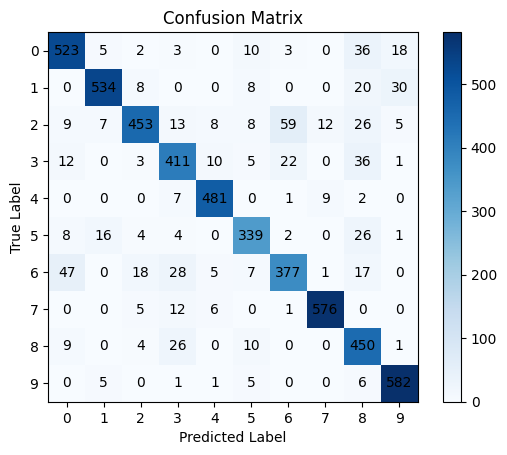

In [12]:
# total_correct = 0
# total_samples = 0

# labels = []
# predictions = []
# with torch.no_grad():
#     for data in (pbar := tqdm(test_data_loader)):
#         pbar.set_description(f"Evaluating")
#         inputs, label = data
#         outputs = net(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total_samples += label.size(0)
#         total_correct +=  (predicted == label).sum().item()
#         labels.append(int(label.cpu().detach().numpy()))
#         predictions.append(int(predicted.cpu().detach().numpy()))

# accuracy = total_correct/total_samples
# print(accuracy)
# cm = confusion_matrix(labels, predictions)
# print("Confusion Matrix:")
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap=['#FFFFFF', '#7BB0D8', '#407ABC'], cbar=False)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()


#calculating accuracy and confusion matrix


import torch
import matplotlib.pyplot as plt
import numpy as np

# ... (rest of your training code)

# Calculate total correct, incorrect classifications, and accuracy
num_classes = 10
total_correct = 0
total_images = 0
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(f'Finished Training: Total Correct: {total_correct}/{total_images} ({total_correct/total_images:.4f} Accuracy)')

# Convert the confusion matrix to a numpy array
confusion_matrix_np = confusion_matrix.detach().cpu().numpy()

# Plot the confusion matrix with values inside the cells
plt.imshow(confusion_matrix_np, cmap='Blues')
plt.colorbar()
plt.xticks(range(num_classes))
plt.yticks(range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Annotate each cell with the numeric value
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, int(confusion_matrix_np[i, j]),
                 ha='center', va='center', color='black')

plt.show()
